In [1]:
import squidpy as sq
import os
import scanpy as sc
import numpy as np

adata = sq.datasets.visium_fluo_adata(path=os.path.join('dataset', 'visium_fluo.h5ad'))
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
pre_processed_adata = adata[:, adata.var['highly_variable']]
cluster_num = len(set(adata.obs['cluster']))

sc.pp.neighbors(pre_processed_adata, n_neighbors=6, random_state=2022)
adj = pre_processed_adata.obsp['connectivities'].todense()
edge_index = np.nonzero(adj)

/mnt/5280e/twang/.conda/envs/torch+pyg/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [6]:
def build_graph(edge_index, data=None, adata=None): 
    import networkx as nx
    import numpy as np

    g = nx.Graph()
    if (adata):
        g.add_nodes_from([i for i in range(adata.X.shape[0])])
    else:
        g.add_nodes_from([i for i in range(data.x.shape[0])])
    edges = [(int(x[0]), int(x[1])) for x in np.array(edge_index).T]
    g.add_edges_from(edges)
    
    return g

In [3]:
def use_louvain(g, cluster_num, init_resolution=1, lr=1e-2, adata=None, data=None, label=None):
    from community import community_louvain
    import numpy as np

    latest_lr = lr
    cnt = 0

    while (True):
        partition = community_louvain.best_partition(g, resolution=init_resolution)
        if (adata):
            result = [str(partition[i]) for i in range(adata.X.shape[0])]
        else:
            result = [str(partition[i]) for i in range(data.x.shape[0])]

        if (len(set(result)) == cluster_num):
            print('>>> resolution: {}, pre_cluster: {}, cluster: {}'.format(init_resolution, len(set(result)), cluster_num))
            break
        elif (len(set(result)) > cluster_num):
            init_resolution += lr
            print('>>> cluster: {}, modify resolution: {}, lr: {}'.format(len(set(result)), init_resolution, lr))
        else:
            init_resolution -= lr
            print('>>> cluster: {}, modify resolution: {}, lr: {}'.format(len(set(result)), init_resolution, lr))

        if (0 == cnt % 5):
            lr = latest_lr
        else:
            lr *= np.random.random()
        
        cnt += 1

    from sklearn import metrics
    from sklearn.preprocessing import LabelEncoder 

    if (adata):
        adata.obs['louvain'] = result
        label = LabelEncoder().fit_transform(adata.obs['cluster'])

    print('ARI: ', metrics.adjusted_rand_score(label, result))

In [4]:
def use_node2vec(edge_index, cluster_num, adata=None, label=None):
    import torch
    from torch_geometric.nn import Node2Vec
    from torch_geometric.data import Data
    from tqdm import tqdm
    from sklearn.cluster import KMeans
    from sklearn import metrics

    data = Data(edge_index=torch.LongTensor(np.array([edge_index[0], edge_index[1]])))

    device = 'cuda'
    torch.manual_seed(2022)
    torch.cuda.manual_seed_all(2022)
    model = Node2Vec(data.edge_index, embedding_dim=16, walk_length=20,
                    context_size=5, walks_per_node=5,
                    num_negative_samples=2, p=4, q=1).to(device)

    loader = model.loader(batch_size=64, shuffle=True)
    optimizer = torch.optim.Adam(list(model.parameters()), lr=1e-3)

    model.train()
    for _ in tqdm(range(200), desc='>>> node2vec'):
        for pos_rw, neg_rw in loader:
            optimizer.zero_grad()
            loss = model.loss(pos_rw.to(device), neg_rw.to(device))
            loss.backward()
            optimizer.step()

    model.eval()
    with torch.no_grad():    
        x = model().cpu().detach().numpy()

    result = [str(k) for k in KMeans(n_clusters=cluster_num, random_state=2022).fit(x).predict(x)]

    from sklearn import metrics
    from sklearn.preprocessing import LabelEncoder 

    if (adata):
        label = LabelEncoder().fit_transform(adata.obs['cluster'])
        adata.obs['node2vec'] = result

    print('ARI: ', metrics.adjusted_rand_score(label, result))

In [5]:
g = build_graph(edge_index, adata=adata)
print(g, cluster_num)

use_louvain(g, cluster_num, adata=adata)
use_node2vec(edge_index, cluster_num, adata=adata)

Graph with 2800 nodes and 10802 edges 15
>>> cluster: 20, modify resolution: 1.01, lr: 0.01
>>> cluster: 23, modify resolution: 1.02, lr: 0.01
>>> cluster: 22, modify resolution: 1.024389962815649, lr: 0.004389962815648905
>>> cluster: 21, modify resolution: 1.0263790099995942, lr: 0.001989047183945182
>>> cluster: 21, modify resolution: 1.028093185062211, lr: 0.0017141750626167797
>>> cluster: 22, modify resolution: 1.0286223320205392, lr: 0.0005291469583281153
>>> cluster: 21, modify resolution: 1.0386223320205392, lr: 0.01
>>> cluster: 21, modify resolution: 1.0402724150340583, lr: 0.0016500830135190337
>>> cluster: 20, modify resolution: 1.0415469424060781, lr: 0.0012745273720198894
>>> cluster: 21, modify resolution: 1.0418117740010289, lr: 0.00026483159495077255
>>> cluster: 19, modify resolution: 1.0419050787560076, lr: 9.330475497867825e-05
>>> cluster: 22, modify resolution: 1.0519050787560076, lr: 0.01
>>> cluster: 20, modify resolution: 1.0559762424539707, lr: 0.004071163697

>>> node2vec: 100%|██████████| 200/200 [00:58<00:00,  3.43it/s]


ARI:  0.7411304779184326


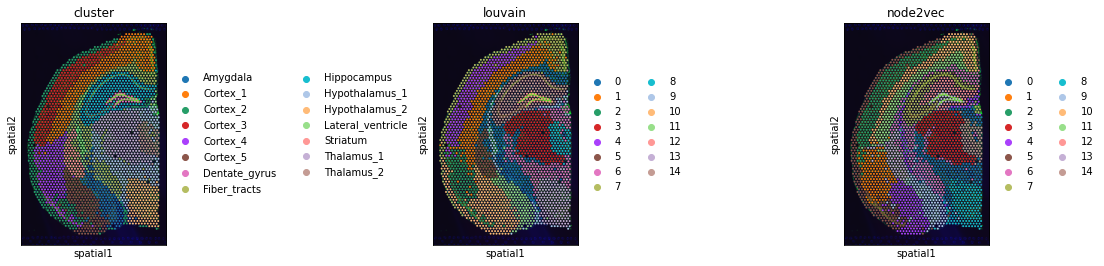

In [6]:
sc.pl.spatial(adata, color=['cluster', 'louvain', 'node2vec'])

In [10]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='dataset/Cora/', name='Cora')
data = dataset[0]
cluster_num = len(set(data.y.numpy()))

cluster_num:  7


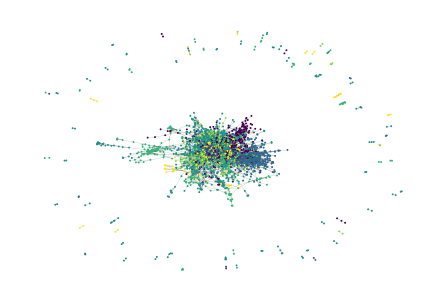

In [11]:
import networkx as nx

g = build_graph(data.edge_index, data=data)
nx.draw(g, pos=nx.spring_layout(g), node_size=8e-1, width=8e-2, node_color=data.y)
print('cluster_num: ' , cluster_num)

In [ ]:
use_louvain(g, cluster_num, data=data, label=data.y)
use_node2vec(edge_index, cluster_num, data=data, label=data.y)

In [ ]:
import scanpy as sc
from dataset import get_visium_fluo_data

adata, clu = get_visium_fluo_data()

from model.utilities import *

data_spatial = build_spatial_graph(adata, 3000, radius=150)